<a href="https://colab.research.google.com/github/boskidisanalysis/pytorch_learning_trip/blob/main/Pytorch_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

Check PyTorch version

In [2]:
torch.__version__

'1.12.1+cu113'

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent. 

In [3]:
# Create *known* parameters
weight = 0.8
bias = 0.4

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.4000],
         [0.4160],
         [0.4320],
         [0.4480],
         [0.4640],
         [0.4800],
         [0.4960],
         [0.5120],
         [0.5280],
         [0.5440]]))

## Split data into training and test sets 

In [4]:
train_split = int(0.8*len(X)) # 80% of the dataset for training and 20% for testing 
x_train, x_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

len(x_train), len(x_test), len(y_train), len(y_test)

(40, 10, 40, 10)


We've got 40 samples for training (X_train & y_train) and 10 samples for testing (X_test & y_test).

The model we'll create is going to try and learn the relationship between X_train & y_train and then we will evaluate on X_test and y_test.

#Visualize

In [5]:
def plot_predictions(train_inputs=x_train,
                     test_inputs=x_test,
                     train_labels=y_train,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  #plot train inputs
  plt.scatter(train_inputs,train_labels, c='b', label='Train Inputs')

  #plot test inputs 
  plt.scatter(test_inputs, test_labels, c='g', label='Test Inputs')
  
  #plot predictions
  if predictions is not None:
    plt.scatter(test_inputs, predictions, c='r', label='Predictions')
  plt.legend(prop={"size": 14});


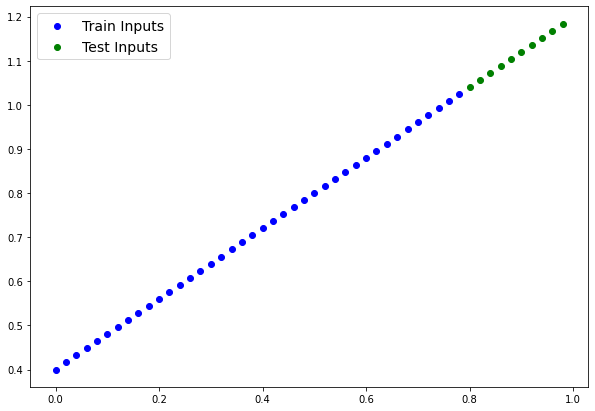

In [6]:
plot_predictions()

## Model

In [7]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights= nn.Parameter(torch.rand(1), 
                               requires_grad=True,)
                               #dtype=torch.float)
    self.bias = nn.Parameter(torch.rand(1),
                             requires_grad=True,)
                             #dtype=torch.float)
    # Forward defines the computation in the model
  def forward(self, x:torch.Tensor)-> torch.Tensor:
    return self.weights*x + self.bias

In [8]:
torch.manual_seed(32)

model = LinearRegressionModel()

Observe what's in our model

In [9]:
list(model.parameters())

[Parameter containing:
 tensor([0.8757], requires_grad=True), Parameter containing:
 tensor([0.2721], requires_grad=True)]

In [10]:
model.state_dict()

OrderedDict([('weights', tensor([0.8757])), ('bias', tensor([0.2721]))])

## Making predictions without training

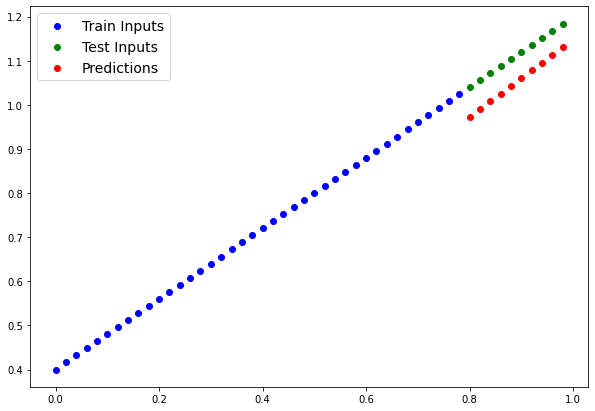

In [11]:
with torch.inference_mode():
  y_preds = model(x_test)

plot_predictions(predictions=y_preds)


# Train the Model
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

In [12]:
# create a loss function
loss_fn = nn.L1Loss() # MAE loss

# create optimizer
optimizer = torch.optim.SGD(params= model.parameters(),
                            lr=0.01)

In [13]:
# Training Loop
torch.manual_seed(32)
epochs = 25

train_loss_values=[]
test_loss_values=[]
epoch_count=[]

for epoch in range(epochs):
  ### Training 
  # Put model in training mode
  model.train()

  # Forward pass the inputs
  y_pred = model(x_train)

  # Calculate Loss
  loss = loss_fn(y_pred, y_train)

  # Zero grad the Optimizer 
  optimizer.zero_grad()

  # Back Propagate the Loss
  loss.backward()

  # Step the Optimizer 
  optimizer.step()

  ### Evaluation
  # Put model in eval mode
  model.eval()
  with torch.inference_mode():
    # Forward test inputs
    test_pred = model(x_test)
    # Calculate loss from eval
    test_loss = loss_fn(test_pred, y_test)
  
  # History Tracking
  if epoch % 5 == 0:
    epoch_count.append(epoch)
    test_loss_values.append(test_loss.detach().numpy())
    train_loss_values.append(loss.detach().numpy())
    print(f'Epoch: {epoch} | Train Loss: {loss} | Validation Loss: {test_loss}')

Epoch: 0 | Train Loss: 0.09842830896377563 | Validation Loss: 0.04713049530982971
Epoch: 5 | Train Loss: 0.04082336649298668 | Validation Loss: 0.020224452018737793
Epoch: 10 | Train Loss: 0.021178852766752243 | Validation Loss: 0.04296315833926201
Epoch: 15 | Train Loss: 0.019018525257706642 | Validation Loss: 0.042975008487701416
Epoch: 20 | Train Loss: 0.017280912026762962 | Validation Loss: 0.03952561691403389


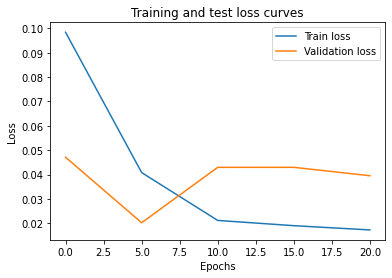

In [14]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Validation loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [15]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.8774])), ('bias', tensor([0.3676]))])

And the original values for weights and bias are:
weights: 0.8, bias: 0.4


## Inference Mode

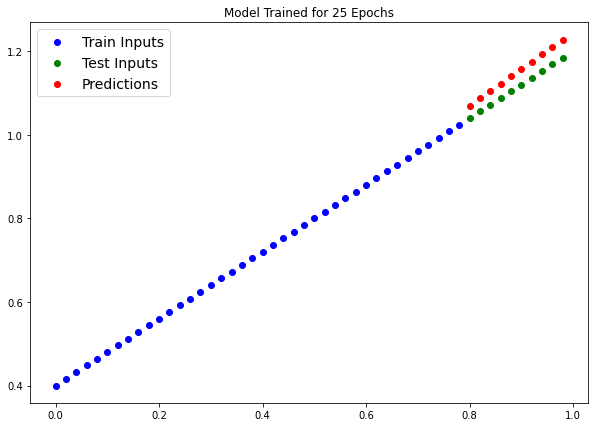

In [16]:
model.eval()
with torch.inference_mode():
  y_preds = model(x_test)

plot_predictions(predictions=y_preds)
plt.title(f'Model Trained for {epochs} Epochs');

## Saving Model

In [17]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pt


## Loading Model

In [18]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

## Creating a Linear Model

In [48]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    #Linear Layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)


In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [50]:
torch.manual_seed(32)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7513]])),
              ('linear_layer.bias', tensor([-0.4559]))]))

In [51]:
next(model_1.parameters()).device

device(type='cpu')

In [52]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## Training

In [53]:
# Loss 
loss_fn = nn.L1Loss()
# Optimizer
optimizer = torch.optim.SGD(params= model_1.parameters(),
                            lr=0.01)

In [54]:
torch.manual_seed(32)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

train_loss_values=[]
test_loss_values=[]
epoch_count=[]

### Training loop
for epoch in range(epochs):
  # Set model to train mode
  model_1.train()

  # Forward Pass
  y_pred = model_1(x_train)
  # Compute Loss
  loss = loss_fn(y_pred, y_train)
  # Zero Grad Optimizer 
  optimizer.zero_grad()
  # Loss Backward 
  loss.backward()
  # Optimizer step
  optimizer.step()

  ### Evaluation
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(x_test)
    eval_loss = loss_fn(test_pred, y_test)
  
  if epoch % 100 ==0: 
    epoch_count.append(epoch)
    test_loss_values.append(eval_loss.detach().numpy())
    train_loss_values.append(loss.detach().numpy())
    print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {eval_loss}")


Epoch: 0 | Train loss: 0.8748565912246704 | Test loss: 0.8857319951057434
Epoch: 100 | Train loss: 0.039799075573682785 | Test loss: 0.09232868999242783
Epoch: 200 | Train loss: 0.005449297837913036 | Test loss: 0.01166391372680664
Epoch: 300 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 400 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 500 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 600 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 700 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 800 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625
Epoch: 900 | Train loss: 0.003996598534286022 | Test loss: 0.005161285400390625


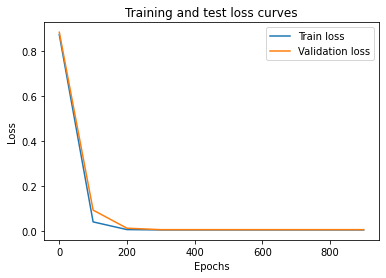

In [57]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Validation loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

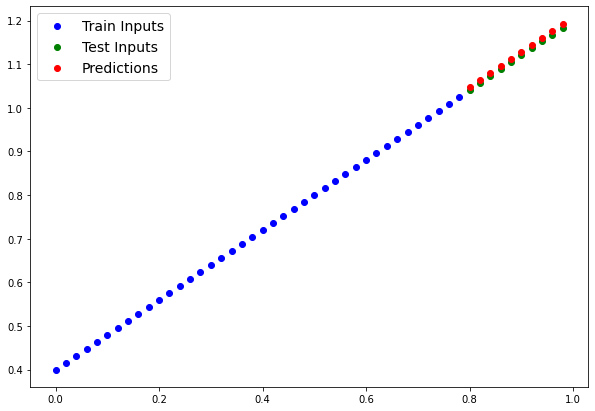

In [55]:
with torch.inference_mode():
  y_preds = model_1(x_test)

plot_predictions(predictions=y_preds)

In [56]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.8086]])),
             ('linear_layer.bias', tensor([0.4006]))])

And the original values for weights and bias are:
weights: 0.8, bias: 0.4
